In [1]:
import pandas as pd
import numpy as np
import pywt
import pandas as pd 
from scipy.stats import skew, kurtosis, median_abs_deviation, moment
import math 
import scipy
import matplotlib.pyplot as plt 
import pywt
import pandas as pd 
import copy
from sklearn.metrics import classification_report , confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, applications, optimizers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import seaborn as sns

2024-04-02 21:03:38.351480: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def rmsValue(array):
    n = len(array)
    squre = 0.0
    root = 0.0
    mean = 0.0
    for i in range(0, n):
        squre += (array[i] ** 2)
    mean = (squre/ (float)(n))
    root = math.sqrt(mean)
    return root

def peak_to_rms_1D(array):

    return np.max(np.abs(array))/rmsValue(array)

def signal_range_1D(array):

    return np.max(array) - np.min(array)


def stats_from_WD(s_signal, wv_type, decomp_lvl):
    coeffs  = pywt.wavedec(s_signal, wv_type, level = decomp_lvl)
    ft_vec = []

    for comp in coeffs:
     ft_vec.append( [np.mean(comp), np.var(comp), np.std(comp), rmsValue(comp),
                   skew(comp), kurtosis(comp), peak_to_rms_1D(comp), rmsValue(comp)/np.mean(np.abs(comp)),
                      median_abs_deviation(comp), moment(comp, moment=2), np.min(comp),
                     np.max(comp), signal_range_1D(comp)] )

    ft_vec = np.reshape(ft_vec, (len(coeffs)*len(ft_vec[0])),) # 1,52
    return ft_vec


def get_train_ft(train_data, dc_type,  dc_lvl):
    
    train_features = []
    for i in range(len(train_data)):
        ft_vec = stats_from_WD(train_data[i,:], dc_type, dc_lvl)
        train_features.append(ft_vec)


    train_features = np.array(train_features)
    
    return train_features

In [3]:
train_data = pd.read_csv('Epileptic Seizure Recognition.csv')
train_labels = train_data.iloc[:,-1]
train_labels = np.array(train_labels, dtype=np.int16)
feat_type = "DWT"    
standard_scaler = True 

if feat_type == "Time":
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   #train_data = sc.fit_transform(train_data)
elif feat_type == "DWT":
   dwt_base = "db4"
   dwt_dc_level = 3
   train_data = train_data.iloc[:,1:-1]
   train_data = np.array(train_data)
   print("Extracting DWT-based features\n")
   train_data = get_train_ft(train_data, dwt_base, dwt_dc_level)


train_labels[train_labels != 1] = 0 # 1 - sezure, 0 - no seizure
n_lab = np.unique(train_labels)   
train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size=0.33, random_state=42)

if standard_scaler:
    sc = StandardScaler()
    train_data = sc.fit_transform(train_data)
    test_data = sc.transform(test_data)


counts = []
for i in range(len(n_lab)):
    counts.append(np.sum(train_labels==i))
counts = counts/sum(counts)

print(f"Train data labels distributions: {counts*100}\n")

Extracting DWT-based features

Train data labels distributions: [80.14276444 19.85723556]



1D-CNN MODEL

Epoch 1/22
217/217 [==============================] - 3s 6ms/step - loss: 0.1721 - accuracy: 0.9425 - val_loss: 0.1288 - val_accuracy: 0.9637
Epoch 2/22
217/217 [==============================] - 1s 4ms/step - loss: 0.0911 - accuracy: 0.9647 - val_loss: 0.0928 - val_accuracy: 0.9689
Epoch 3/22
217/217 [==============================] - 1s 4ms/step - loss: 0.0729 - accuracy: 0.9714 - val_loss: 0.0888 - val_accuracy: 0.9663
Epoch 4/22
217/217 [==============================] - 1s 4ms/step - loss: 0.0605 - accuracy: 0.9743 - val_loss: 0.0885 - val_accuracy: 0.9650
Epoch 5/22
217/217 [==============================] - 1s 6ms/step - loss: 0.0568 - accuracy: 0.9774 - val_loss: 0.0838 - val_accuracy: 0.9598
Epoch 6/22
217/217 [==============================] - 1s 5ms/step - loss: 0.0505 - accuracy: 0.9795 - val_loss: 0.0883 - val_accuracy: 0.9650
Epoch 7/22
217/217 [==============================] - 1s 5ms/step - loss: 0.0432 - accuracy: 0.9830 - val_loss: 0.0781 - val_accuracy: 0.9676
Epoch 

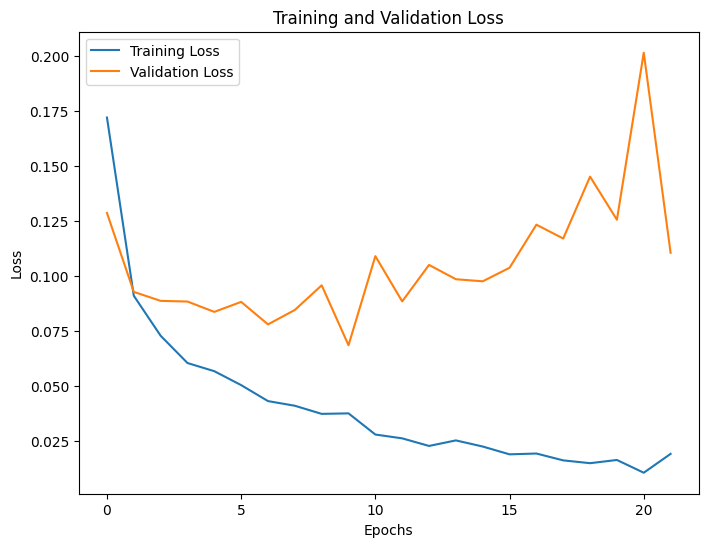

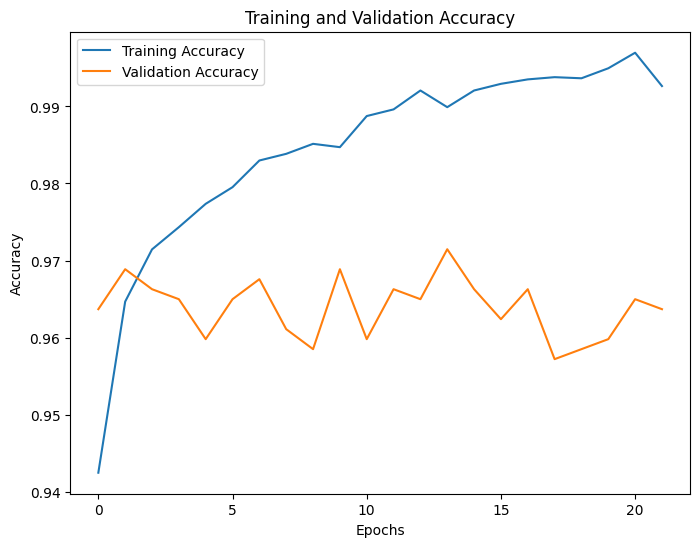

119/119 [==============================] - 0s 2ms/step - loss: 0.1008 - accuracy: 0.9747
Test accuracy (CNN): 97.47035503387451%
119/119 [==============================] - 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.95      0.93      0.94       770

    accuracy                           0.97      3795
   macro avg       0.96      0.96      0.96      3795
weighted avg       0.97      0.97      0.97      3795



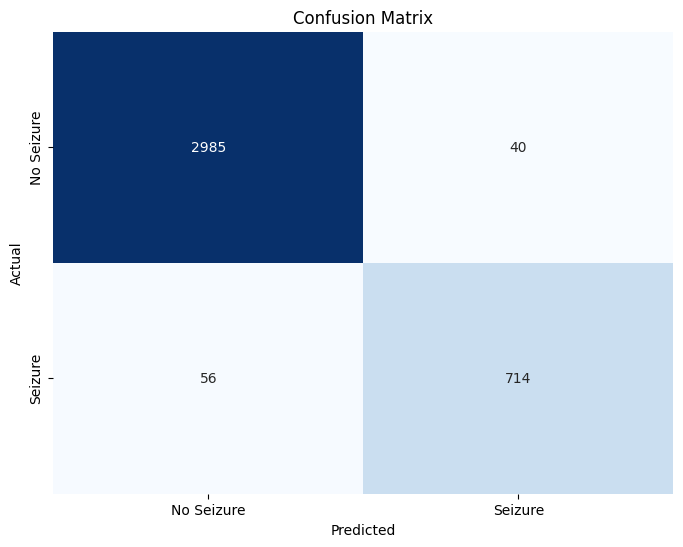

In [17]:
#CNN
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    
train_data = train_data.reshape(train_data.shape[0], train_data.shape[1], 1)
test_data = test_data.reshape(test_data.shape[0], test_data.shape[1], 1)
input_shape = train_data.shape[1:]
model = create_cnn(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)

# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

test_loss, test_acc_cnn = model.evaluate(test_data, test_labels)
print(f'Test accuracy (CNN): {test_acc_cnn*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


LSTM MODEL

Epoch 1/22
217/217 [==============================] - 17s 49ms/step - loss: 0.2051 - accuracy: 0.9376 - val_loss: 0.1606 - val_accuracy: 0.9507
Epoch 2/22
217/217 [==============================] - 9s 40ms/step - loss: 0.1527 - accuracy: 0.9476 - val_loss: 0.1554 - val_accuracy: 0.9429
Epoch 3/22
217/217 [==============================] - 9s 40ms/step - loss: 0.1396 - accuracy: 0.9528 - val_loss: 0.1244 - val_accuracy: 0.9559
Epoch 4/22
217/217 [==============================] - 9s 41ms/step - loss: 0.1345 - accuracy: 0.9540 - val_loss: 0.1213 - val_accuracy: 0.9585
Epoch 5/22
217/217 [==============================] - 10s 44ms/step - loss: 0.1300 - accuracy: 0.9546 - val_loss: 0.1238 - val_accuracy: 0.9572
Epoch 6/22
217/217 [==============================] - 9s 41ms/step - loss: 0.1265 - accuracy: 0.9543 - val_loss: 0.1168 - val_accuracy: 0.9611
Epoch 7/22
217/217 [==============================] - 9s 40ms/step - loss: 0.1219 - accuracy: 0.9554 - val_loss: 0.1175 - val_accuracy: 0.95

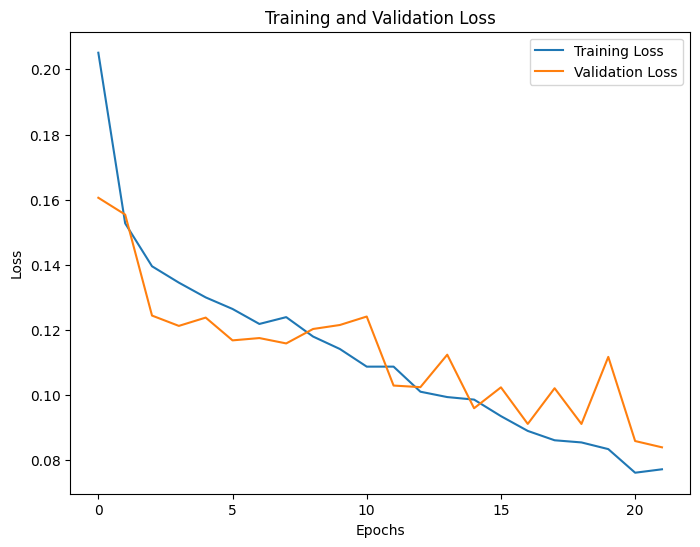

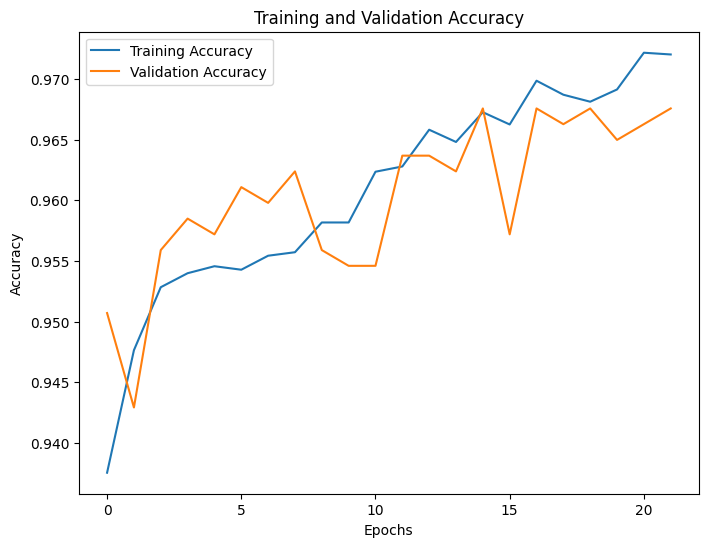

119/119 [==============================] - 2s 14ms/step - loss: 0.0896 - accuracy: 0.9694
Test accuracy (LSTM): 96.94334864616394%
119/119 [==============================] - 3s 14ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.91      0.92       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.95      3795
weighted avg       0.97      0.97      0.97      3795



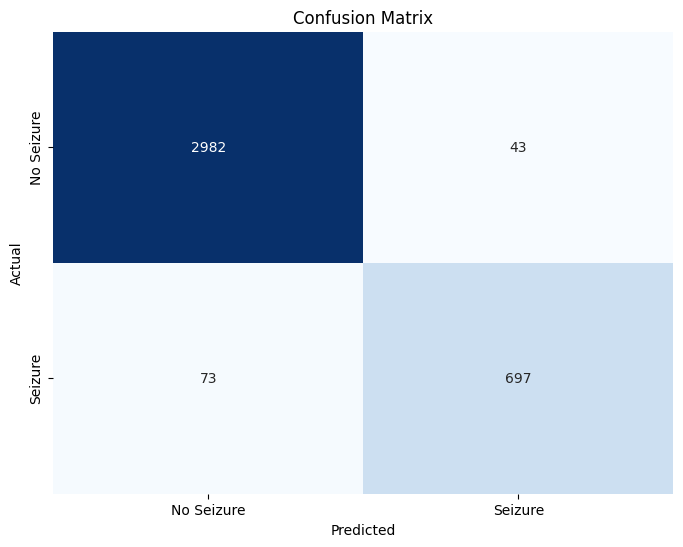

In [27]:
#LSTM
def create_lstm(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))  # Return sequences for stacking LSTM layers
    model.add(layers.LSTM(32, return_sequences=True))  # Additional LSTM layer
    model.add(layers.LSTM(32))  # Additional LSTM layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
train_data = np.reshape(train_data, (train_data.shape[0], train_data.shape[1], 1))
test_data = np.reshape(test_data, (test_data.shape[0], test_data.shape[1], 1))
input_shape = train_data.shape[1:]
model = create_lstm(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history=model.fit(train_data, train_labels, epochs=22, batch_size=32, validation_split=0.1)
# Plotting training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc_lstm = model.evaluate(test_data, test_labels)
print(f'Test accuracy (LSTM): {test_acc_lstm*100}%')
predictions = model.predict(test_data)
predictions = (predictions > 0.5)  
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

CNN + LSTM ENSEMBLE LEARNING MODEL

Epoch 1/11
217/217 [==============================] - 4s 11ms/step - loss: 0.1654 - accuracy: 0.9469 - val_loss: 0.1056 - val_accuracy: 0.9637
Epoch 2/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0893 - accuracy: 0.9670 - val_loss: 0.0834 - val_accuracy: 0.9702
Epoch 3/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0672 - accuracy: 0.9740 - val_loss: 0.1067 - val_accuracy: 0.9507
Epoch 4/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0566 - accuracy: 0.9765 - val_loss: 0.0986 - val_accuracy: 0.9650
Epoch 5/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0496 - accuracy: 0.9781 - val_loss: 0.0813 - val_accuracy: 0.9650
Epoch 6/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0552 - accuracy: 0.9782 - val_loss: 0.0771 - val_accuracy: 0.9637
Epoch 7/11
217/217 [==============================] - 1s 6ms/step - loss: 0.0448 - accuracy: 0.9830 - val_loss: 0.0708 - val_accuracy: 0.9663
Epoch

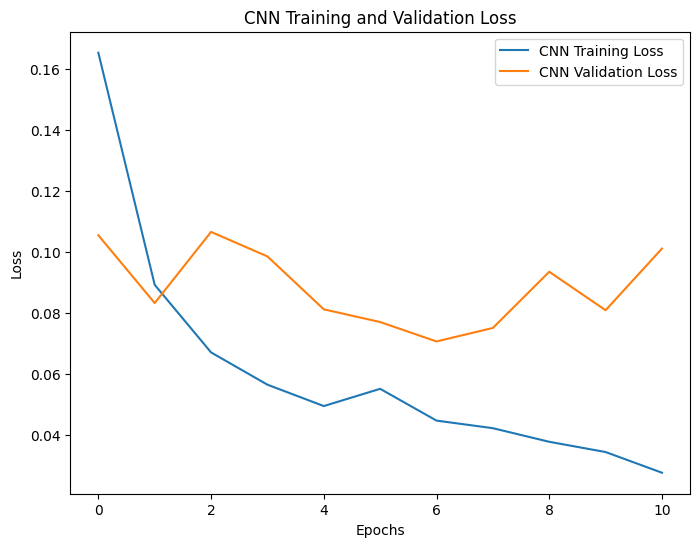

119/119 [==============================] - 3s 14ms/step
Ensemble Model Test Accuracy: 97.65480895915678%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.92      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



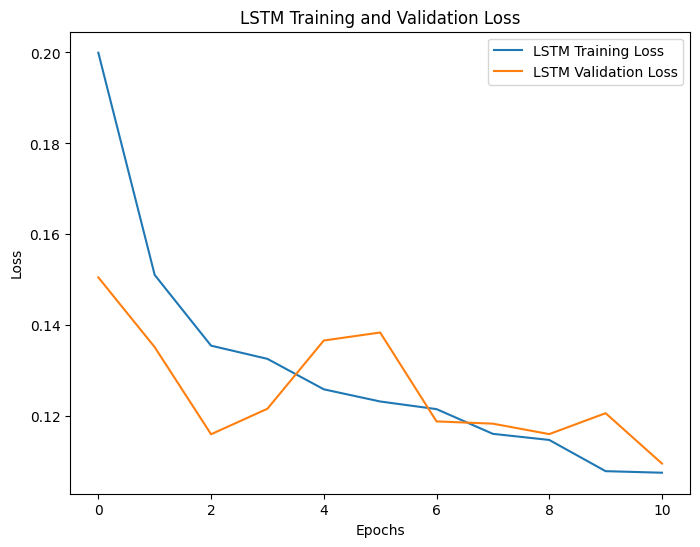

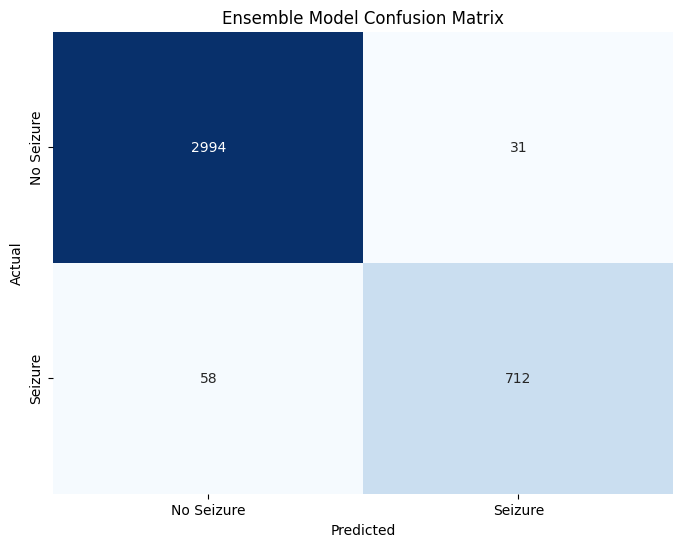

In [63]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, LSTM, Dense, concatenate, Dropout
from sklearn.metrics import accuracy_score

# Define CNN model
def create_cnn(input_shape):
    model = models.Sequential()
    model.add(layers.Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(64, kernel_size=3, activation='relu'))
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(128, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.MaxPooling1D(pool_size=2))
    model.add(layers.Conv1D(256, kernel_size=3, activation='relu'))  # Additional Conv1D layer
    model.add(layers.GlobalAveragePooling1D())  # Global average pooling
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model
    

# Define LSTM model
def create_lstm(input_shape):
    model = models.Sequential()
    model.add(layers.LSTM(64, return_sequences=True, input_shape=input_shape))  # Return sequences for stacking LSTM layers
    model.add(layers.LSTM(32, return_sequences=True))  # Additional LSTM layer
    model.add(layers.LSTM(32))  # Additional LSTM layer
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))  # Additional Dense layer
    model.add(layers.Dense(1, activation='sigmoid'))  # Output layer with sigmoid for binary classification
    return model

# Create CNN model
cnn_model = create_cnn(input_shape)

# Create LSTM model
lstm_model = create_lstm(input_shape)

# Compile CNN and LSTM models
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN and LSTM models
cnn_history = cnn_model.fit(train_data, train_labels, epochs=11, batch_size=32, validation_split=0.1)
lstm_history = lstm_model.fit(train_data, train_labels, epochs=11, batch_size=32, validation_split=0.1)

# Plotting training and validation loss for CNN
plt.figure(figsize=(8, 6))
plt.plot(cnn_history.history['loss'], label='CNN Training Loss')
plt.plot(cnn_history.history['val_loss'], label='CNN Validation Loss')
plt.title('CNN Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation loss for LSTM
plt.figure(figsize=(8, 6))
plt.plot(lstm_history.history['loss'], label='LSTM Training Loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation Loss')
plt.title('LSTM Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Make predictions using CNN and LSTM models
cnn_predictions = cnn_model.predict(test_data)
lstm_predictions = lstm_model.predict(test_data)

# Combine predictions using simple averaging
ensemble_predictions = (cnn_predictions + lstm_predictions) / 2

# Convert probabilities to binary predictions
ensemble_predictions_binary = (ensemble_predictions > 0.5).astype(int)

# Evaluate ensemble model
ensemble_accuracy = accuracy_score(test_labels, ensemble_predictions_binary)
print(f'Ensemble Model Test Accuracy: {ensemble_accuracy*100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)

conf_matrix = confusion_matrix(test_labels, ensemble_predictions_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


DECISION TREE MODEL

Decision Tree Classifier Accuracy: 96.7588932806324%
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.91      0.92       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.95      3795
weighted avg       0.97      0.97      0.97      3795



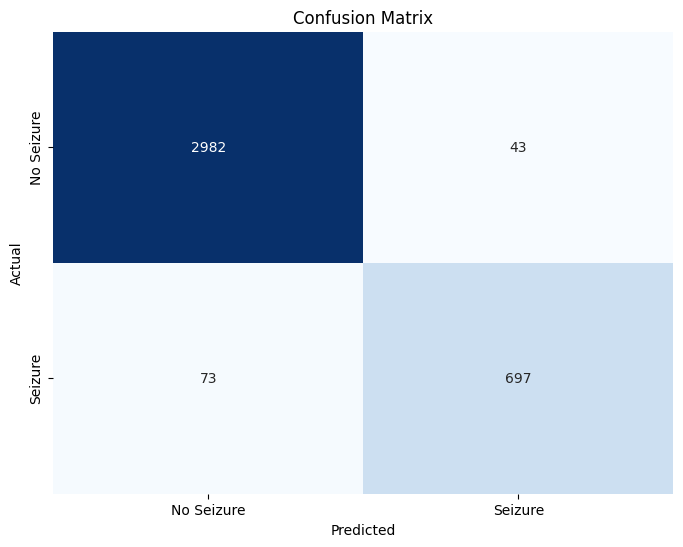

In [31]:
#DecisionTreeClassifier
train_data = train_data.reshape(train_data.shape[0], -1)
test_data = test_data.reshape(test_data.shape[0], -1)
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(train_data, train_labels)
dt_predictions = dt_classifier.predict(test_data)
dt_accuracy = accuracy_score(test_labels, dt_predictions)
print(f'Decision Tree Classifier Accuracy: {dt_accuracy*100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

RANDOM FOREST MODEL

Random Forest Classifier Accuracy: 98.39262187088273%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.96      0.96      0.96       770

    accuracy                           0.98      3795
   macro avg       0.97      0.98      0.98      3795
weighted avg       0.98      0.98      0.98      3795



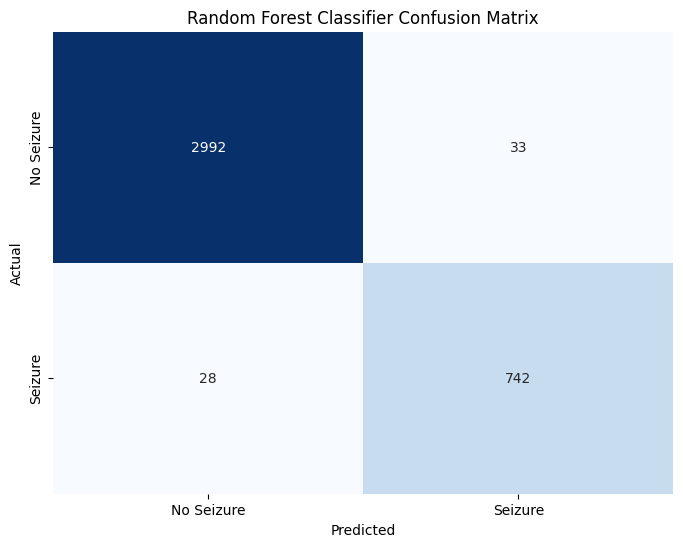

In [33]:
from sklearn.ensemble import RandomForestClassifier

train_data_reshaped = train_data.reshape(train_data.shape[0], -1)
test_data_reshaped = test_data.reshape(test_data.shape[0], -1)
random_forest_classifier = RandomForestClassifier()
random_forest_classifier.fit(train_data_reshaped, train_labels)
predictions = random_forest_classifier.predict(test_data_reshaped)
rf_accuracy = accuracy_score(test_labels, predictions)
print(f'Random Forest Classifier Accuracy: {rf_accuracy * 100}%')
print("Classification Report:")
print(classification_report(test_labels, predictions))
rf_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("Random Forest Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



ADA BOOSTING

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoost Classifier Accuracy: 97.60210803689064%
AdaBoost Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3025
           1       0.93      0.95      0.94       770

    accuracy                           0.98      3795
   macro avg       0.96      0.97      0.96      3795
weighted avg       0.98      0.98      0.98      3795



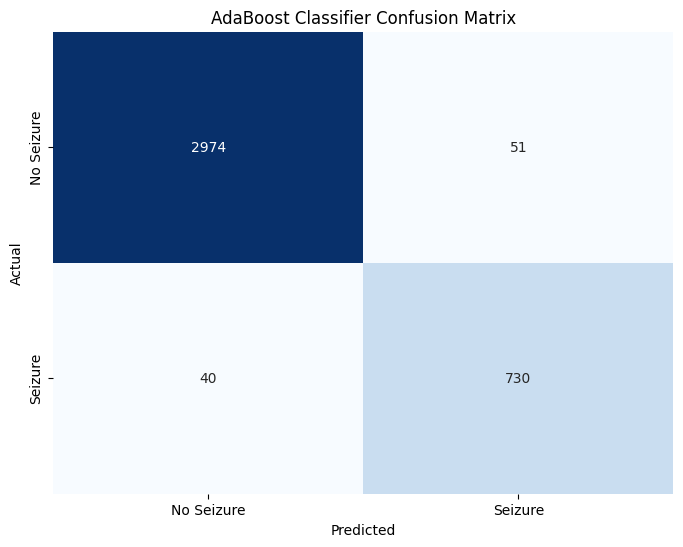

In [37]:
base_estimator = DecisionTreeClassifier(max_depth=1)
adaboost_classifier = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50, learning_rate=1.0, random_state=42)
adaboost_classifier.fit(train_data, train_labels)
adaboost_predictions = adaboost_classifier.predict(test_data)
adaboost_accuracy = accuracy_score(test_labels, adaboost_predictions)
print(f'AdaBoost Classifier Accuracy: {adaboost_accuracy*100}%')
print("AdaBoost Classifier Classification Report:")
print(classification_report(test_labels, adaboost_predictions))
adaboost_conf_matrix = confusion_matrix(test_labels, adaboost_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(adaboost_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("AdaBoost Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

SVM MODEL

SVM Classifier Test Accuracy: 97.78656126482214%
SVM Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3025
           1       0.95      0.94      0.95       770

    accuracy                           0.98      3795
   macro avg       0.97      0.96      0.97      3795
weighted avg       0.98      0.98      0.98      3795



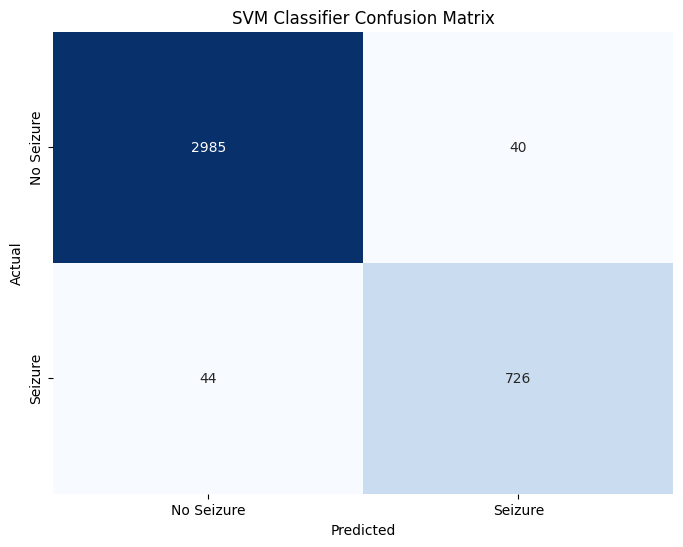

In [40]:
#SVM
from sklearn.svm import SVC
svm_classifier = SVC(kernel='rbf', random_state=42)
svm_classifier.fit(train_data, train_labels)
svm_predictions = svm_classifier.predict(test_data)
svm_accuracy = accuracy_score(test_labels, svm_predictions)
print(f'SVM Classifier Test Accuracy: {svm_accuracy*100}%')
print("SVM Classifier Classification Report:")
print(classification_report(test_labels, svm_predictions))
svm_conf_matrix = confusion_matrix(test_labels, svm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(svm_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("SVM Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

KNN MODEL

KNN Classifier Accuracy: 97.15415019762847%
KNN Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3025
           1       0.94      0.92      0.93       770

    accuracy                           0.97      3795
   macro avg       0.96      0.95      0.96      3795
weighted avg       0.97      0.97      0.97      3795



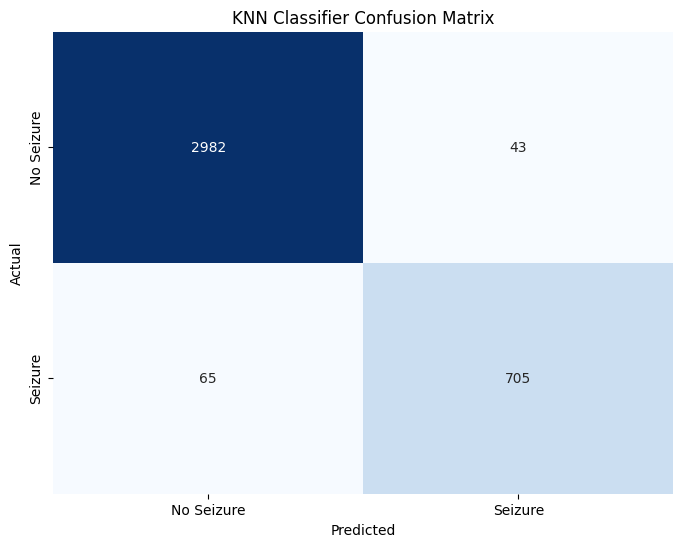

In [49]:
#KNN
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

knn_classifier = KNeighborsClassifier(n_neighbors=5)  

knn_classifier.fit(train_data, train_labels)

# Predict on the test data
predictions = knn_classifier.predict(test_data)
knn_accuracy = accuracy_score(test_labels, predictions)
print(f"KNN Classifier Accuracy: {knn_accuracy * 100}%")
print("KNN Classification Report:")
print(classification_report(test_labels, predictions))
knn_conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(knn_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["No Seizure", "Seizure"], yticklabels=["No Seizure", "Seizure"])
plt.title("KNN Classifier Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



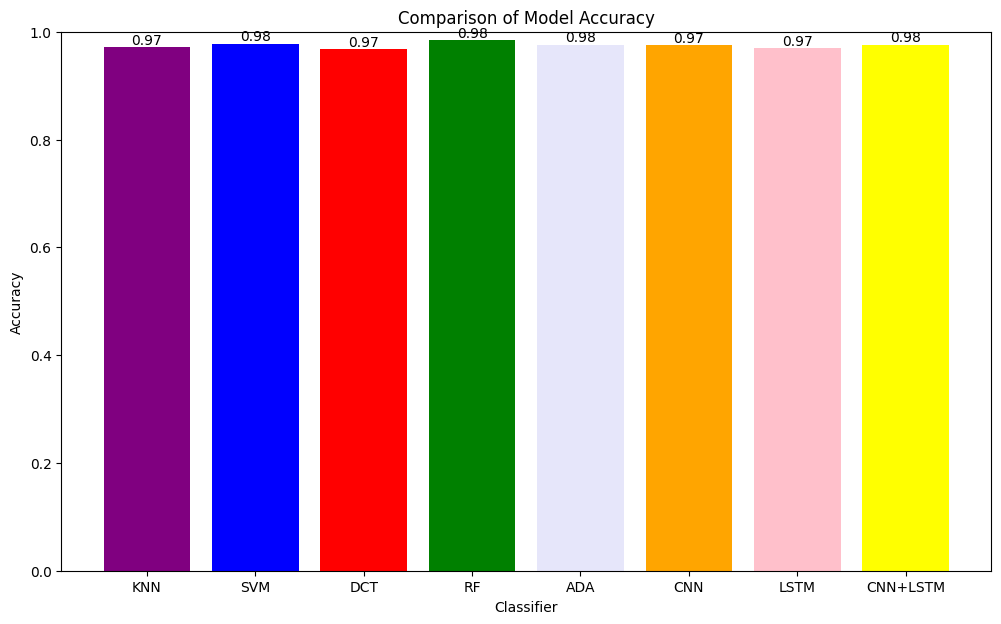

In [62]:
import matplotlib.pyplot as plt

accuracy_scores = [knn_accuracy, svm_accuracy, dt_accuracy, rf_accuracy,adaboost_accuracy, test_acc_cnn,test_acc_lstm,ensemble_accuracy]
classifier_names = ['KNN', 'SVM', 'DCT', 'RF', 'ADA', 'CNN','LSTM','CNN+LSTM']

plt.figure(figsize=(12, 7)) 
bars = plt.bar(classifier_names, accuracy_scores, color=['purple', 'blue', 'red', 'green', 'lavender', 'orange', 'pink','yellow'])
plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracy")
plt.ylim(0, 1)  

for bar, label in zip(bars, accuracy_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, round(label, 2), ha='center', va='bottom')

plt.show()